##### ProbCT inference results on NASA's AirMSPI real-world data.
##### You are very welcome to use this code. For this, clearly acknowledge
##### the source of this code, and cite our papers described in the readme file.

##### Copyright (c) Roi Ronen. The python code is available for
##### non-commercial use and exploration.  For commercial use contact the
##### authors. The authors are not liable for any damages or loss that might be
##### caused by use or connection to this code.
##### All rights reserved.

##### This source code is licensed under the GPL-3.0 license found in the
##### LICENSE file in the root directory of this source tree.
---
# ProbCT Results for AirMSPI Data
---
## This notebook demonstrates ProbCT estimation and downstram products using real-world cloud images, imaged by the AirMSPI instrument [[1]]. The cloud processed in this notebook is part of a PODEX [[2]] scene above the North Pacific Ocean [[3]].
##   
##     
[1]: https://asdc.larc.nasa.gov/project/AIRMSPI   
     

[2]: https://asdc.larc.nasa.gov/project/AIRMSPI/AirMSPI_PODEX_Ellipsoid-projected_Georegistered_Radiance_Data_5/20130206-date-imagery
[3]: https://asdc.larc.nasa.gov/documents/airmspi/images/ELLIPSOID/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202754Z_NorthPacificOcean-32N123W_000N_F01_V005.jpg

In [1]:
import os, time
import warnings
warnings.filterwarnings('ignore')
import hydra
from hydra import compose, initialize
import numpy as np
from omegaconf import OmegaConf
from omegaconf import DictConfig
from dataloader.airmspi_dataset import get_real_world_airmspi_datasets, trivial_collate
from ProbCT.CTnetV2 import *
from ProbCT.util.discritize import get_pred_and_conf_from_discrete
from scene.cameras import AirMSPICameras
from scene.volumes import Volumes
import scipy.io as sio
from renderer.shdom_renderer import DiffRendererSHDOM_AirMSPI
import matplotlib.pyplot as plt
CONFIG_DIR = os.path.join("../", "configs")
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [2]:
# Load ProbCT model
MODEL_DIR = os.path.join("../", "models", "ProbCT_airmspi")
with initialize(version_base='1.1', config_path=CONFIG_DIR, job_name="test_app"):
        cfg = compose(config_name="test_airmspi")
        print(OmegaConf.to_yaml(cfg))


# Set the relevant seeds for reproducibility
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)

# Device on which to run
if torch.cuda.is_available() and cfg.debug == False:
    n_device = torch.cuda.device_count()
    cfg.gpu = 0 if n_device==1 else cfg.gpu
    device = f"cuda:{cfg.gpu}"
else:
    warnings.warn(
        "Please note that although executing on CPU is supported,"
        + "the training is unlikely to finish in reasonable time."
    )
    device = "cpu"


resume_cfg_path = os.path.join(MODEL_DIR.split('/checkpoints')[0],'.hydra/config.yaml')
net_cfg = OmegaConf.load(resume_cfg_path)
cfg = OmegaConf.merge(net_cfg,cfg)
cfg.checkpoint_resume_path = os.path.join(MODEL_DIR,"model.pth")

# Initialize ProbCT model
model = CTnetV2(cfg=cfg, n_cam=cfg.data.n_cam)

# Load model
print(f"Resuming from checkpoint {cfg.checkpoint_resume_path}.")
loaded_data = torch.load(cfg.checkpoint_resume_path, map_location=device)
model.load_state_dict(loaded_data["model"])
model.to(device)
model.eval().float()

seed: 3
debug: false
gpu: 0
rerender: true
checkpoint_resume_path: /home/roironen/LearnedCloudCT/models/ProbCT_airmspi/model.pth
data:
  dataset_name: 32N123W_experiment_cloud1
  n_val: -1
ct_net:
  val_n_query: 1000
  val_mask_type: space_carving
  query_point_val_method: all
  conf_type: prob
  encoder_mode: train
min_mask_points: 0
shdom:
  n_jobs: 35
  use_forward_grid: true
  add_rayleigh: true

Using torchvision resnet50_fpn encoder
Resuming from checkpoint ../models/ProbCT_airmspi/model.pth.


CTnetV2(
  (_image_encoder): Backbone(
    (model): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): Sequential()
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (re

In [3]:
# Load AirMSPI raw data
DATA_DIR = os.path.join("../", "data")
val_dataset = get_real_world_airmspi_datasets(cfg=cfg, data_root=DATA_DIR)
val_image, grid, images_mapping_list, pixel_centers_list, masks, gt_image,projection_list = val_dataset[0]
val_image = torch.tensor(val_image,device=device).float()[None]
masks = torch.tensor(masks,device=device)[None]
val_volume = Volumes(torch.unsqueeze(masks.float(), 1), grid)
val_camera = AirMSPICameras(mapping=torch.tensor(np.array(images_mapping_list), device=device).float(),
                              centers=torch.tensor(np.array(pixel_centers_list)).float(), device=device)

In [4]:
with torch.no_grad():
    est_vols = torch.zeros(masks.shape, device=masks.device)
    net_start_time = time.time()

    val_out = model(
        val_camera,
        val_image,
        val_volume,
        masks
    )
    time_net = time.time() - net_start_time
    val_out["output"], val_out["output_conf"], probs = get_pred_and_conf_from_discrete(val_out["output"],
                                                                                       cfg.cross_entropy.min,
                                                                                       cfg.cross_entropy.max,
                                                                                       cfg.cross_entropy.bins,
                                                                                       pred_type=cfg.ct_net.pred_type,
                                                                                       conf_type=cfg.ct_net.conf_type)
    for i, (out_vol, m) in enumerate(zip(val_out["output"],masks)):
        if m is None:
            est_vols[i] = out_vol.squeeze(1)
        else:
            # m = m.reshape(-1)
            est_vols[i][m] = out_vol.flatten()
            if val_out["output_conf"] is not None:
                conf_vol = torch.ones_like(est_vols[i]) * torch.nan
                prob_vol = torch.ones(*est_vols[i].shape, probs[0].shape[-1],
                                      device=out_vol.device) * torch.nan
                val_out["output_conf"][0] = val_out["output_conf"][0]
                prob_vol[m] = probs[0]
                prob_vol = prob_vol.cpu().numpy()

In [5]:
# render excluded image and compare to ground-truth
diff_renderer_shdom = DiffRendererSHDOM_AirMSPI(cfg=cfg)
cloud = est_vols[0]
mask = masks[0]
diff_renderer_shdom.render(cloud, mask, val_volume, gt_image, [projection_list])

Reading mie table from file: /home/roironen/LearnedCloudCT/renderer/../pyshdom4VIP-CT/mie_tables/polydisperse/Water_660nm.scat


tensor(3.7360, device='cuda:0')

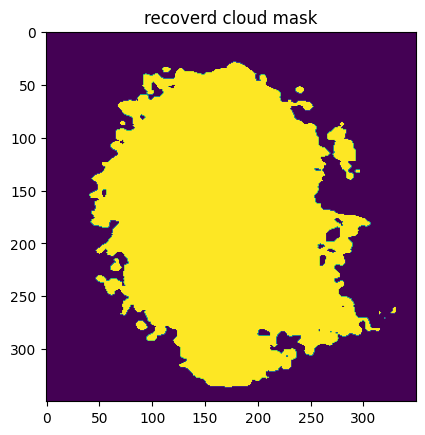

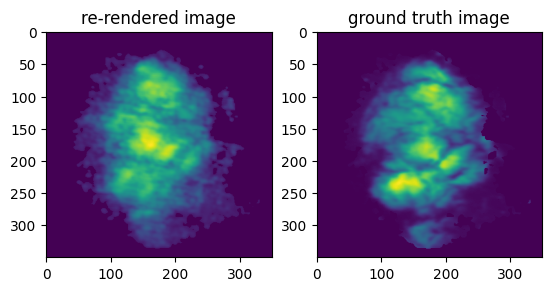

Text(0, 0.5, 're-rendered image')

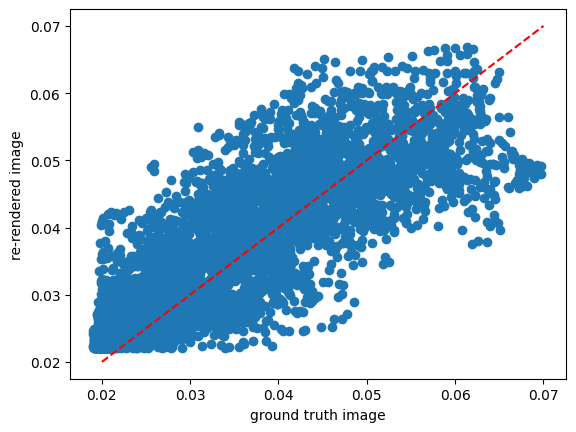

In [38]:
# show ground-truth vs. re-rendered images scatter plot
im_mask = diff_renderer_shdom.images>0.022
plt.imshow(im_mask[0])
plt.title('recoverd cloud mask')
plt.show()

fig, axs = plt.subplots(1, 2)

images = np.zeros_like(diff_renderer_shdom.images) + diff_renderer_shdom.gt_images[0,0,0]
diff_renderer_shdom.images.shape
images[im_mask] = diff_renderer_shdom.images[im_mask]
gt_images = np.zeros_like(diff_renderer_shdom.gt_images) + diff_renderer_shdom.gt_images[0,0,0]
gt_images[im_mask] = diff_renderer_shdom.gt_images[im_mask]

axs[0].imshow(images[0])
axs[1].imshow(gt_images[0])
axs[0].title.set_text('re-rendered image')
axs[1].title.set_text('ground truth image')


plt.show()

n_pix = im_mask.sum()
i = np.random.permutation(n_pix)
i = i[:int(0.1*n_pix)]

plt.scatter(diff_renderer_shdom.gt_images[im_mask][i],diff_renderer_shdom.images[im_mask][i])
plt.plot([0.02,0.07],[0.02,0.07],'--r')
plt.xlabel('ground truth image')
plt.ylabel('re-rendered image')

In [67]:
# show estimated 3D volume
import mayavi.mlab as mlab
def show_scatterer(volume, ShowVolumeBox=True, data_type = 'Extinction [1/km]'):
   
    """
    Show the scatterer in 3D with Mayavi.
    """
   
    ShowVolumeBox = True
   
    dx = 0.05
    dy = 0.05
    dz = 0.04
    xgrid = np.linspace(0,72*dx,72)
    ygrid = np.linspace(0,72*dy,72)
    zgrid = np.linspace(0,32*dz,32)
   
    show_field = np.nan_to_num(volume)
  
   
    mlab.figure(size=(600, 600))
    X, Y, Z = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
    figh = mlab.gcf()
    src = mlab.pipeline.scalar_field(X, Y, Z, show_field, figure=figh)
   
    src.spacing = [dx, dy, dz]
    src.update_image_data = True
   
    isosurface = mlab.pipeline.iso_surface(src, contours=[0.1*show_field.max(),\
                                                          0.2*show_field.max(),\
                                                          0.3*show_field.max(),\
                                                          0.4*show_field.max(),\
                                                          0.5*show_field.max(),\
                                                          0.6*show_field.max(),\
                                                          0.7*show_field.max(),\
                                                          0.8*show_field.max(),\
                                                          0.9*show_field.max(),\
                                                          ],opacity=0.9,figure=figh)
   
    mlab.outline(figure=figh,color = (1, 1, 1))  # box around data axes
    mlab.orientation_axes(figure=figh)
    mlab.axes(figure=figh, xlabel="x (km)", ylabel="y (km)", zlabel="z (km)")
    color_bar = mlab.colorbar(title=data_type, orientation='vertical', nb_labels=5)    
       
    if(ShowVolumeBox):
        # The _max is one d_ after the last point of the xgrid (|_|_|_|_|_|_|_->|).
        x_min = xgrid[0]
        x_max = round(xgrid[-1].item() + dx,5)
       
        y_min = ygrid[0]
        y_max = round(ygrid[-1].item() + dy,5)
       
        z_min = zgrid[0]
        z_max = round(zgrid[-1].item() + dz,5)    
       
        xm = [x_min, x_max, x_max, x_min, x_max, x_max, x_min, x_min ]
        ym = [y_min, y_min, y_min, y_min, y_max, y_max, y_max, y_max ]
        zm = [z_min, z_min, z_max, z_max, z_min, z_max, z_max, z_min ]
        # Medium cube
        triangles = [[0,1,2],[0,3,2],[1,2,5],[1,4,5],[2,5,6],[2,3,6],[4,7,6],[4,5,6],[0,3,6],[0,7,6],[0,1,4],[0,7,4]];
        obj = mlab.triangular_mesh( xm, ym, zm, triangles,color = (0.0, 0.17, 0.72),opacity=0.3,figure=figh)

             
    mlab.show()    

show_scatterer(cloud.cpu().numpy())

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [68]:
# show estimated uncertainty (normalized entropy)
entropy = np.squeeze(np.sum(prob_vol*np.log2(prob_vol),3)) / (np.log2(1/cfg.cross_entropy.bins));
show_scatterer(entropy)

In [69]:
# Show the 3D Adiabatic fraction field
reff = sio.loadmat('files/reff_airmspi.mat')['reff']
lwc_ad = sio.loadmat('files/lwc_ad.mat')['lwc_ad'] * 1e5 #units
#LWC_ad is in 10m steps from cloud base, sample to AirMSPI recovery vertical resolution of 40m

lwc_z=np.arange(1,lwc_ad.size,4)
lwc_ad=lwc_ad[lwc_z]
lwc_ad=lwc_ad[:reff.shape[-1]].T
Q = 2
ext_ad= 3/4 * Q * lwc_ad / reff
AF = cloud.cpu().numpy() / ext_ad
AF[np.isnan(AF)]=0
AF[np.isinf(AF)]=0
show_scatterer(AF)